In [1]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np

In [2]:
data = pd.read_csv("data.csv")

In [3]:
data.head()

,Unnamed: 0,temp,humidity
0,0,23.90,57.96
1,1,26.22,57.42
2,2,25.97,52.15
3,3,26.16,55.86
4,4,25.16,56.43


In [4]:
data_set = data.values[:,1:3]

In [5]:
data_set.shape

(10000, 2)

In [6]:
data_set

array([[23.9 , 57.96],
       [26.22, 57.42],
       [25.97, 52.15],
       ...,
       [12.33, 36.59],
       [10.99, 37.58],
       [12.87, 36.89]])

In [7]:
temp = torch.empty(len(data_set[:,0])-3,4)
for i in range(len(data_set[:,0])-3):
    temp[i,0] = torch.tensor(data_set[i,0])
    temp[i,1] = torch.tensor(data_set[i+1,0])
    temp[i,2] = torch.tensor(data_set[i+2,0])
    temp[i,3] = torch.tensor(data_set[i+3,0])

In [8]:
temp_x = temp[:,0:3]
temp_y = temp[:,-1]

In [9]:
temp_x_train, temp_x_test, temp_y_train, temp_y_test = train_test_split(temp_x, temp_y,  
                                                                        test_size = 0.1, shuffle = False)

In [10]:
print(temp_x_train.shape)
print(temp_y_train.shape)
print(temp_x_test.shape)
print(temp_y_test.shape)

torch.Size([8997, 3])
torch.Size([8997])
torch.Size([1000, 3])
torch.Size([1000])


In [11]:
print(temp_x_train[0:5,:])
print(temp_y_train[0:5])
print(temp_x_test[2,:])
print(temp_y_test[2])
print(type(temp_y_test[2]))

tensor([[23.9000, 26.2200, 25.9700],
        [26.2200, 25.9700, 26.1600],
        [25.9700, 26.1600, 25.1600],
        [26.1600, 25.1600, 27.2200],
        [25.1600, 27.2200, 25.7800]])
tensor([26.1600, 25.1600, 27.2200, 25.7800, 27.3800])
tensor([47.3400, 48.5200, 48.0000])
tensor(46.7900)
<class 'torch.Tensor'>


In [12]:
class DNN(nn.Module):
    def __init__(self):
        super(DNN, self).__init__()
        self.fc1 = nn.Linear(3, 32)
        self.fc2 = nn.Linear(32, 1)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.2)
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [13]:
# 定义训练函数
def train(model, device, train_loader, optimizer, criterion):
    model.train()
    for data, target in train_loader:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

# 定义测试函数
def test(model, device, test_loader, criterion):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()
    test_loss /= len(test_loader.dataset)
    return test_loss

In [14]:
if __name__ == '__main__':
  
    x_train = temp_x_train
    y_train = temp_y_train
    train_data = TensorDataset(x_train, y_train)
    train_loader = DataLoader(train_data, batch_size=32, shuffle=False)
    
    x_test = temp_x_test
    y_test = temp_y_test
    test_data = TensorDataset(x_test, y_test)
    test_loader = DataLoader(test_data, batch_size=32, shuffle=False)
    
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = DNN().to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.01)
    criterion = nn.MSELoss()
    
   
    epochs = 50
    best_loss = 1000
    for epoch in range(epochs):
        train(model, device, train_loader, optimizer, criterion)
        test_loss = test(model, device, test_loader, criterion)
        print('Epoch {}, Test Loss: {:.4f}'.format(epoch+1, test_loss))
        if best_loss > test_loss:
            best_loss = test_loss
            torch.save(model,"DNN_temperature.pt")
            print('best model saved')



/Users/jiaxingzhang/env/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/jiaxingzhang/env/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([5])) that is different to the input size (torch.Size([5, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/jiaxingzhang/env/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same 

Epoch 1, Test Loss: 0.3396
best model saved
Epoch 2, Test Loss: 0.5457
Epoch 3, Test Loss: 0.3621
Epoch 4, Test Loss: 0.2323
best model saved
Epoch 5, Test Loss: 0.3802
Epoch 6, Test Loss: 0.2697
Epoch 7, Test Loss: 0.3821
Epoch 8, Test Loss: 0.9452
Epoch 9, Test Loss: 0.3378
Epoch 10, Test Loss: 0.3889
Epoch 11, Test Loss: 0.3728
Epoch 12, Test Loss: 0.9823
Epoch 13, Test Loss: 0.3516
Epoch 14, Test Loss: 0.2347
Epoch 15, Test Loss: 0.2963
Epoch 16, Test Loss: 0.3205
Epoch 17, Test Loss: 0.4283
Epoch 18, Test Loss: 0.4832
Epoch 19, Test Loss: 0.3827
Epoch 20, Test Loss: 0.5376
Epoch 21, Test Loss: 0.4129
Epoch 22, Test Loss: 0.3724
Epoch 23, Test Loss: 0.4173
Epoch 24, Test Loss: 0.5794
Epoch 25, Test Loss: 0.5839
Epoch 26, Test Loss: 0.3033
Epoch 27, Test Loss: 0.2997
Epoch 28, Test Loss: 0.3142
Epoch 29, Test Loss: 0.4573
Epoch 30, Test Loss: 0.4928
Epoch 31, Test Loss: 0.6010
Epoch 32, Test Loss: 0.4555
Epoch 33, Test Loss: 0.4221
Epoch 34, Test Loss: 0.2501
Epoch 35, Test Loss: 0.

In [15]:
x = np.arange(0,100)
test = temp_x_test[0:100,:]
test.shape

torch.Size([100, 3])

In [16]:
result = np.zeros([100])
predictor = torch.load("DNN_temperature.pt")
for i in range(len(test)):
    result[i] = predictor(test[i])

In [17]:
type(result)

numpy.ndarray

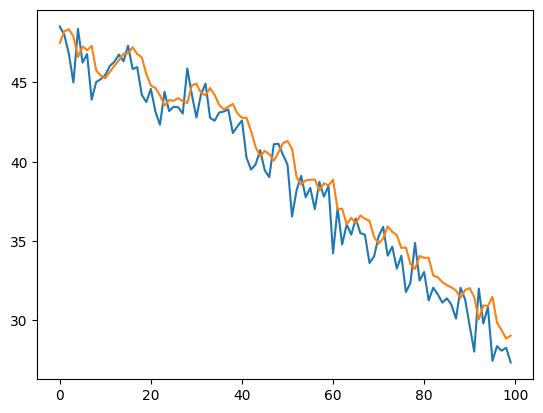

In [18]:
plt.plot(x,temp_y_test[0:100])
plt.plot(x,result)

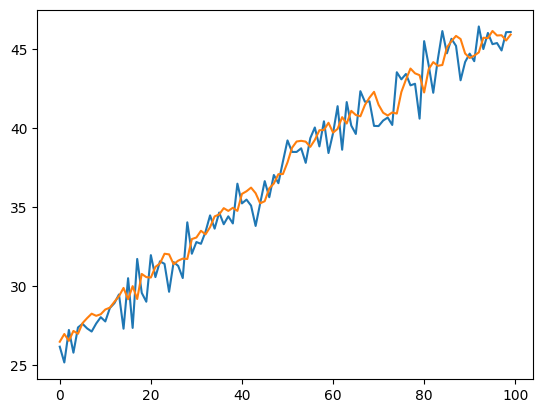

In [19]:
train = temp_x_train[0:100,:]
result_train = np.zeros([100])
for i in range(len(train)):
    result_train[i] = predictor(train[i])
plt.plot(x,temp_y_train[0:100])
plt.plot(x,result_train)

In [20]:
difference = temp_y_test[0:100] - result
print(difference[0:10])

tensor([ 1.0287, -0.2062, -1.5591, -2.9035,  1.7731, -1.0166, -0.2484, -3.3789,
        -0.7262, -0.2234], dtype=torch.float64)
